# Import CIVET data from txt files
* **Objectives:** 
    1. Cluster CIVET vertices into ROIs (based on an atlas)
    2. Generate ROI/Subject based distributions to find outlier

* **Atlases:** 
    1. AAL
    2. Spect_cluster

In [5]:
# Basic Imports
import numpy as np
#import h5py as h5
from sklearn.externals import joblib
import collections
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.cross_validation import KFold
import pickle
import re
import os
import os.path
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from collections import Counter
%matplotlib inline

In [6]:
# Some defs

# filter CT columns and compute stats
def get_ct_data(df_data,qc_list,cleanup_names):        
    #drop QC fails    
    if cleanup_names:
        std_list = []
        for f in qc_list:
            filename = f.split('_', 1)[1]
            filename = filename.rsplit('_', 1)[0]
            std_list.append(filename)

        qc_list = std_list
    
    df_data = df_data[df_data['filename'].isin(qc_list)]
    print('QC passed scans: {}'.format(len(df_data)))
    
    ct_cols = ['filename'] + list(df_data.columns[pd.Series(df_data.columns).str.contains('CT')])
    ct_data = df_data[ct_cols]
    
    #find NaNs
    nan_subs = ct_data[ct_data.isnull().any(axis=1)].index
    print('{} NaN subjects found'.format(len(nan_subs)))
    print(nan_subs)
    
    #drop NaNs
    ct_data.dropna(inplace=True)
    
    #append ImageUID col
    iid_list = []
    for f in ct_data['filename'].values:        
        iid = f
#         iid = f.rsplit('_', 1)[1]
#         iid = iid.split('I')[1]
        iid_list.append(iid)

    ct_data['ImageUID'] = iid_list

    #Summary Stats
    return ct_data

#Statistical test to check if two cohorts have similar distibutions 
def get_significance(df1,df2,cols):
    t_vals = []
    p_vals = []

    for col in cols:
        a = df1[col].values
        b = df2[col].values
        t_vals.append(ttest_ind(a,b)[0])
        p_vals.append(ttest_ind(a,b)[1])

    ttest_df = pd.DataFrame(columns=['ct_roi','t_val','p_val'])
    ttest_df['ct_roi'] = cols
    ttest_df['t_val'] = t_vals
    ttest_df['p_val'] = p_vals
    
    return ttest_df

# Tag outliers
def tag_outliers(df,thresold,max_outlier_roi_count,max_outlier_sub_count):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = (df < (Q1 - thresold*IQR)) | (df > (Q3 + thresold*IQR))
    
    print('Subjects with most frequent outlier values')
    df_outliers = pd.DataFrame(outlier_mask.sum(1),columns=['outlier_roi_count'])
    outlier_subs = df_outliers[df_outliers['outlier_roi_count'] > max_outlier_roi_count].sort_values(by='outlier_roi_count',ascending=False)
    print(outlier_subs)
    print('')
    
    print('ROIs with most frequet outlier values')
    df_outliers = pd.DataFrame(outlier_mask.sum(0),columns=['outlier_sub_count'])
    outlier_rois = df_outliers[df_outliers['outlier_sub_count'] > max_outlier_sub_count].sort_values(by='outlier_sub_count',ascending=False)  
    print(outlier_rois)
    
    return list(outlier_subs.index),list(outlier_rois.index)


In [18]:
# Paths
baseline_dir = '/projects/nbhagwat/datasets/'
aibl_aal_csv = '{}AIBL/aibl_civet_aal.csv'.format(baseline_dir)
aibl_qc_csv = '{}AIBL/aibl_QC.csv'.format(baseline_dir)
aibl_data_download_csv = '/home/nbhagwat/Downloads/Series_ADNI_7_18_2017.csv'

In [65]:
df_data_download = pd.read_csv(aibl_data_download_csv)
df_data_download[df_data_download['Subject']==1577]

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
170,451197,1577,Patient,F,79,1,MRI,MPRAGE ADNI confirmed,Original,5/05/2014,DCM,10/19/2016


In [27]:
len(aibl_mri_meta_data)

1080

In [8]:
# Read CIVET data
#aibl
df_aal_data = pd.read_csv(aibl_aal_csv)
df_qc = pd.read_csv(aibl_qc_csv)
cleanup_names = True
print('dataset: AIBL')
print('data_total: {}, qc_total: {}, #0:{}, #0.5:{}, #1:{}'.format(len(df_aal_data),len(df_qc),
                                                                 len(df_qc[df_qc['score']==0.0]),
                                                                 len(df_qc[df_qc['score']==0.5]),
                                                                 len(df_qc[df_qc['score']==1])))
aibl_ct_data = get_ct_data(df_aal_data,df_qc[df_qc['score']!=-1]['filename'].values,cleanup_names)
#aibl_ct_data_strictQC = get_ct_data(df_aal_data,df_qc[df_qc['score']==1]['filename'].values,cleanup_names)

dataset: AIBL
data_total: 536, qc_total: 543, #0:60, #0.5:262, #1:221
QC passed scans: 536
0 NaN subjects found
Int64Index([], dtype='int64')


/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/tigrlab/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj/lib/python2.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
aibl_ct_data['RID'],aibl_ct_data['RID_leftover'],aibl_ct_data['RID_leftover_2'] = aibl_ct_data['ImageUID'].str.split('_',2).str
len(set(aibl_ct_data['RID'].values))

151

In [63]:
aibl_idx = '/projects/nbhagwat/datasets/AIBL/aibl_idx_sorted.txt'
aibl_idx_data = pd.read_csv(aibl_idx,delim_whitespace=True,header=None)
aibl_idx_data.columns=['count','RID']

traj_csv = '/projects/nbhagwat/Traj_prediction/AIBL/exp_setup/AIBL_trajectory_labels_2class_MMSE_3cstp_from_m54_autoselect.csv'
traj_data = pd.read_csv(traj_csv)
traj1_rid = traj_data[(traj_data['traj']==1)]['RID'].values
print(len(traj1_rid))

traj1_rid_2tp = aibl_idx_data[(aibl_idx_data['count']!=1)&(aibl_idx_data['RID'].isin(traj1_rid))]
print(traj1_rid_2tp['RID'].values)


[1091,1157,354,374,911,942,113,12,232,28,366,380,509,57,571,609,914,945,111,365,721,740,851]

31
[1091 1157  354  374  911  942  113   12  232   28  366  380  509   57  571
  609  914  945  111  365  721  740  851]


In [9]:
####################
## Read AIBL tables
####################

aibl_table_dir = '/projects/nbhagwat/Traj_prediction/AIBL/Data_extract_3.2.5/'
aibl_mmse_file = 'aibl_mmse_28-Apr-2015_linux.csv'
aibl_dx_file = 'aibl_pdxconv_28-Apr-2015.csv'
aibl_dob_file = 'aibl_ptdemog_28-Apr-2015.csv'
aibl_apoe_file = 'aibl_apoeres_28-Apr-2015.csv'
aibl_mri_meta_file = 'aibl_mri3meta_28-Apr-2015.csv'
aibl_filename_viscode_file = '/projects/nbhagwat/Traj_prediction/AIBL/filename_viscode_table.csv'

aibl_mmse_data = pd.read_csv(aibl_table_dir + aibl_mmse_file)
aibl_dx_data = pd.read_csv(aibl_table_dir + aibl_dx_file)
aibl_dob_data = pd.read_csv(aibl_table_dir + aibl_dob_file)[['RID','PTDOB']]
aibl_apoe_data = pd.read_csv(aibl_table_dir + aibl_apoe_file)[['RID','APOE4']]
aibl_mri_meta_data = pd.read_csv(aibl_table_dir + aibl_mri_meta_file)[['RID','VISCODE','EXAMDATE']]

aibl_mmse_data = aibl_mmse_data.rename(columns={'MMSCORE': 'MMSE'})
aibl_mmse_data_bl = aibl_mmse_data[aibl_mmse_data['VISCODE']=='bl'][['RID','EXAMDATE','VISCODE','MMSE']]

aibl_dx_data_bl = aibl_dx_data[aibl_dx_data['VISCODE']=='bl'][['RID','DXCURREN']]
aibl_dx_data_bl = aibl_dx_data_bl.rename(columns={'DXCURREN': 'DX_cat'})
aibl_dx_data_bl['DX_cat'] = aibl_dx_data_bl['DX_cat'].apply(pd.to_numeric)

#split MRI_meta table columns to match with CT examdates from filename to map filenames and viscode
#aibl_mri_meta_data['EXAM_month'],aibl_mri_meta_data['EXAM_day'],aibl_mri_meta_data['EXAM_year'] = aibl_mri_meta_data['EXAMDATE'].str.split('/',3).str
aibl_filename_viscode_data = pd.read_csv(aibl_filename_viscode_file)

In [66]:
aibl_mri_meta_data['EXAMDATE'].apply(str)
mri_meta_data_rids = aibl_mri_meta_data[(aibl_mri_meta_data['VISCODE']=='bl')]

len(set(aibl_ct_data['RID'].apply(pd.to_numeric).values) & set(mri_meta_data_rids['RID'].values))

91

In [10]:
aibl_demo_data = pd.merge(aibl_mmse_data_bl,aibl_dob_data,how='inner',on='RID')
aibl_demo_data = pd.merge(aibl_demo_data,aibl_apoe_data,how='inner',on='RID')
aibl_demo_data = pd.merge(aibl_demo_data,aibl_dx_data_bl,how='inner',on='RID')

aibl_demo_data['EXAM_month'],aibl_demo_data['EXAM_day'],aibl_demo_data['EXAM_year'] = aibl_demo_data['EXAMDATE'].str.split('/',3).str
aibl_demo_data['PTDOB_clean'] = aibl_demo_data['PTDOB'].str.lstrip('/')
aibl_demo_data[['EXAM_year','PTDOB_clean']] = aibl_demo_data[['EXAM_year','PTDOB_clean']].apply(pd.to_numeric)
aibl_demo_data['AGE'] = aibl_demo_data['EXAM_year'] - aibl_demo_data['PTDOB_clean']
aibl_demo_data

,RID,EXAMDATE,VISCODE,MMSE,PTDOB,APOE4,DX_cat,EXAM_month,EXAM_day,EXAM_year,PTDOB_clean,AGE
0,2,09/16/2011,bl,30,/1941,0,1,09,16,2011.0,1941,70.0
1,3,10/12/2007,bl,30,/1939,1,1,10,12,2007.0,1939,68.0
2,4,02/02/2007,bl,27,/1922,0,1,02,02,2007.0,1922,85.0
3,5,02/05/2007,bl,30,/1933,0,2,02,05,2007.0,1933,74.0
4,10,02/26/2007,bl,21,/1925,2,3,02,26,2007.0,1925,82.0
5,11,03/01/2007,bl,29,/1917,0,1,03,01,2007.0,1917,90.0
6,12,03/06/2007,bl,28,/1928,1,2,03,06,2007.0,1928,79.0
7,14,03/06/2007,bl,30,/1941,1,1,03,06,2007.0,1941,66.0
8,15,03/15/2007,bl,28,/1920,0,2,03,15,2007.0,1920,87.0
9,16,03/21/2007,bl,27,/1926,1,1,03,21,2007.0,1926,81.0


In [11]:
ct_cols = list(aibl_ct_data.columns[pd.Series(aibl_ct_data.columns).str.contains('CT')])
# aibl_ct_data['RID'],aibl_ct_data['filename_EXAMDATE'], aibl_ct_data['RID_leftover'] = aibl_ct_data['filename'].str.split('_',2).str
# aibl_ct_data['EXAM_year'],aibl_ct_data['EXAM_month'], aibl_ct_data['EXAM_day'] = aibl_ct_data['filename_EXAMDATE'].str.split('-',2).str
# aibl_ct_data['RID'] = aibl_ct_data['RID'].apply(pd.to_numeric)
aibl_ct_data_vis = pd.merge(aibl_ct_data,aibl_filename_viscode_data,on=['filename'],how='inner')
aibl_ct_data_vis_demo = pd.merge(aibl_ct_data_vis,aibl_mmse_data,on=['RID','VISCODE'],how='inner')
aibl_ct_data_vis_demo[['filename','RID','MMSE','VISCODE']]

,filename,RID,MMSE,VISCODE
0,101_2008-09-05_12_44_13.0,101,30,m18
1,101_2010-05-14_11_06_09.0,101,28,m36
2,101_2011-11-23_10_58_06.0,101,30,m54
3,1013_2008-03-28_10_09_20.0,1013,27,bl
4,1013_2010-02-05_11_01_44.0,1013,20,m18
5,1013_2011-09-06_10_13_11.0,1013,24,m36
6,1050_2008-04-09_14_49_31.0,1050,30,bl
7,1050_2009-10-26_15_24_14.0,1050,30,m18
8,1050_2011-08-09_11_45_42.0,1050,29,m36
9,1050_2012-12-04_09_45_54.0,1050,29,m54


In [12]:
# Merge CT data with ADNIMERGE using ImageUIDs
print('Lenient QC')
print('scans before merge (scans:aibl ct, demo):{},{}'.format(len(aibl_ct_data), len(aibl_demo_data)))
aibl_ct_demo_data = pd.merge(aibl_ct_data_vis_demo,aibl_demo_data,on='RID')
print('scans after merge (scans:aibl):{}'.format(len(aibl_ct_demo_data)))

Lenient QC
scans before merge (scans:aibl ct, demo):536,861
scans after merge (scans:aibl):475


In [13]:
# Tag outliers
max_outlier_roi_count = 35
max_outlier_sub_count = 35

#ADNI2
print('aibl quantitative outliers')
outlier_subs,outlier_rois = tag_outliers(aibl_ct_data[ct_cols],1.5,max_outlier_roi_count,max_outlier_sub_count)
print(aibl_ct_data.loc[outlier_subs,'filename'].values)

#drop the outlier rows
print('subx before outlier drop: {}'.format(len(aibl_ct_data)))
aibl_ct_data.drop(aibl_ct_data.index[outlier_subs],inplace=True)
print('subx after outlier drop: {}'.format(len(aibl_ct_data)))

aibl quantitative outliers
Subjects with most frequent outlier values
Empty DataFrame
Columns: [outlier_roi_count]
Index: []

ROIs with most frequet outlier values
Empty DataFrame
Columns: [outlier_sub_count]
Index: []
[]
subx before outlier drop: 536
subx after outlier drop: 536


ct_data_1 dx:1, subx:389
ct_data_1 dx:2, subx:71
ct_data_1 dx:3, subx:16


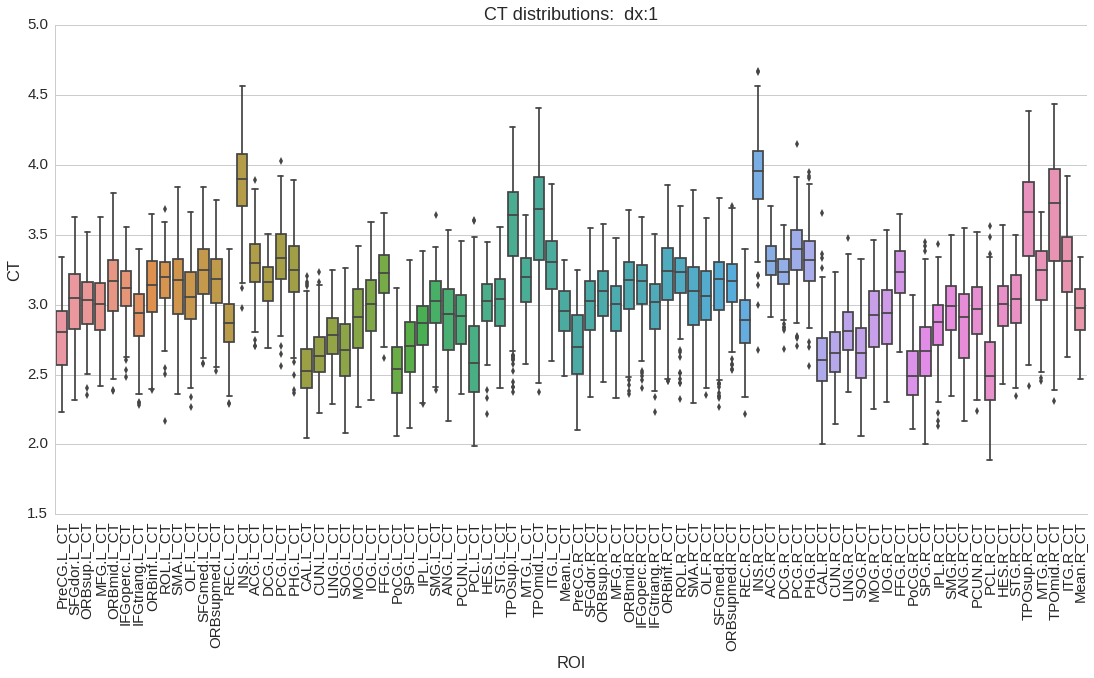

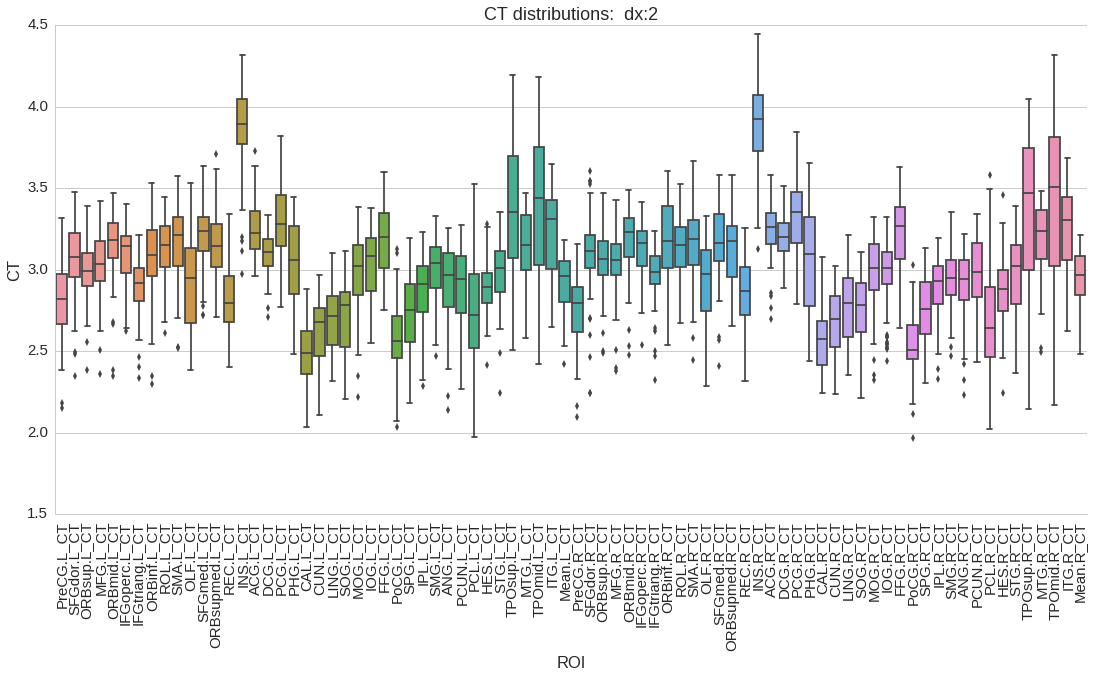

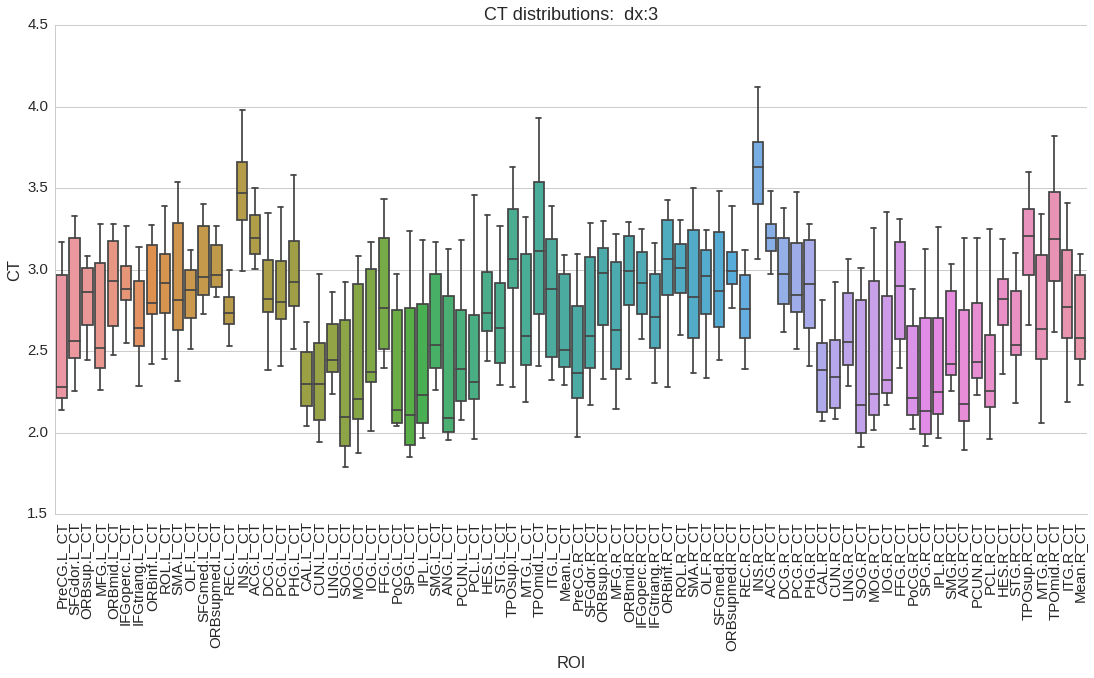

In [11]:
# Plots
# Check effect of QC (grouped by Dx)

plt.rcParams['figure.figsize'] = (20, 20)
sns.set(font_scale=1.5) 

for dx in [1,2,3]:    
    #Lenient QC
    ct_data_1 = aibl_ct_demo_data[aibl_ct_demo_data.DX_cat==dx][['RID'] + ct_cols]
    ct_data_1_melt = pd.melt(ct_data_1,id_vars='RID',value_vars=ct_cols,var_name='ROI', value_name='CT')
   
    print('ct_data_1 dx:{}, subx:{}'.format(dx,len(ct_data_1)))
        
    #Distributions
    sns.set_style("whitegrid")    
    g1 = sns.factorplot(y='CT',x='ROI',kind='box', data=ct_data_1_melt,size=8, aspect=2)
    g1.set_xticklabels(rotation=90)   
    plt.title('CT distributions:  dx:{}'.format(dx))
    

In [194]:
adni2_ct_data.describe()

,PreCG.L_CT,SFGdor.L_CT,ORBsup.L_CT,MFG.L_CT,ORBmid.L_CT,IFGoperc.L_CT,IFGtriang.L_CT,ORBinf.L_CT,ROL.L_CT,SMA.L_CT,...,TPOsup.R_CT,MTG.R_CT,TPOmid.R_CT,ITG.R_CT,Mean.R_CT,ImageUID,ADAS13,ADAS11,MMSE,DX_cat
count,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,...,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,900.000000,901.000000,916.000000,1115.000000
mean,2.779386,2.950307,3.046730,2.951123,3.172042,3.147406,2.950820,3.202426,3.210238,3.158583,...,3.556001,3.202589,3.607307,3.307612,2.974772,351147.753363,16.788889,11.206437,26.274017,0.810762
std,0.212363,0.223540,0.208415,0.195819,0.215621,0.197209,0.191854,0.234451,0.197813,0.236946,...,0.432817,0.232221,0.445570,0.269163,0.174306,60706.118518,14.094544,10.572585,4.994885,0.685232
min,2.120100,2.009400,2.334100,2.125400,2.396700,2.290400,2.324600,2.427400,2.488400,2.336900,...,1.846600,2.272700,1.881600,2.348300,2.357000,228524.000000,0.000000,0.000000,0.000000,0.000000
25%,2.641500,2.801650,2.916650,2.817600,3.040050,3.021200,2.835850,3.053400,3.079250,3.016350,...,3.330950,3.079850,3.382000,3.151650,2.867150,293747.000000,7.000000,5.000000,25.000000,0.000000
50%,2.777400,2.975300,3.050100,2.968400,3.171700,3.164000,2.969700,3.222500,3.215900,3.179400,...,3.645300,3.242300,3.703100,3.340400,2.999700,351996.000000,13.000000,8.000000,28.000000,1.000000
75%,2.934800,3.102350,3.178500,3.086700,3.315000,3.286900,3.082100,3.362300,3.357000,3.306750,...,3.861750,3.366000,3.918100,3.484900,3.097500,413730.000000,22.250000,15.000000,29.000000,1.000000
max,3.352700,3.637900,3.813500,3.563000,4.058300,3.712700,3.502500,3.936000,3.812900,3.998300,...,4.474900,3.789600,4.514800,3.990600,3.433500,451521.000000,85.000000,70.000000,30.000000,2.000000


In [12]:
ct_data_1.describe()

,RID,PreCG.L_CT,SFGdor.L_CT,ORBsup.L_CT,MFG.L_CT,ORBmid.L_CT,IFGoperc.L_CT,IFGtriang.L_CT,ORBinf.L_CT,ROL.L_CT,...,ANG.R_CT,PCUN.R_CT,PCL.R_CT,HES.R_CT,STG.R_CT,TPOsup.R_CT,MTG.R_CT,TPOmid.R_CT,ITG.R_CT,Mean.R_CT
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,891.000000,2.559969,2.763362,2.821944,2.696200,2.898531,2.912219,2.722250,2.888488,2.933400,...,2.388056,2.585587,2.444194,2.781019,2.638144,3.164862,2.699694,3.188569,2.809181,2.670250
std,237.445573,0.408664,0.400408,0.210015,0.353365,0.287653,0.213737,0.259407,0.266247,0.295039,...,0.467497,0.354224,0.430979,0.247088,0.276317,0.284940,0.390806,0.373060,0.375461,0.288329
min,567.000000,2.142500,2.256500,2.445000,2.260700,2.476300,2.551900,2.284800,2.419300,2.454400,...,1.894700,2.230900,1.959700,2.357700,2.182500,2.660700,2.058400,2.618700,2.189400,2.296100
25%,658.000000,2.211575,2.459825,2.658975,2.395175,2.652600,2.815850,2.531100,2.728800,2.735100,...,2.072225,2.338175,2.159675,2.663025,2.475250,2.967675,2.450375,2.928825,2.578450,2.451800
50%,1013.000000,2.283400,2.564050,2.865600,2.518750,2.929450,2.879700,2.639600,2.794050,2.915800,...,2.176600,2.433100,2.259100,2.819250,2.535650,3.209750,2.634250,3.191050,2.772100,2.580500
75%,1102.000000,2.969350,3.193800,3.010550,3.041725,3.176300,3.022650,2.931775,3.153475,3.096300,...,2.752125,2.794025,2.602325,2.940950,2.869075,3.370300,3.092800,3.479150,3.121050,2.970550
max,1139.000000,3.173000,3.328000,3.083400,3.278800,3.278100,3.271100,3.141000,3.273900,3.394000,...,3.196700,3.194400,3.252000,3.191600,3.104900,3.598100,3.342500,3.820800,3.411100,3.096700


* **Create subject master-table** 
    1. Baseline demographics 
    2. Timepoint columns with links to scans and clinical scores
    


In [14]:
#Populate master_sub_table with timepoint ImageUIDs that link to master_scan_table for CT and CS values
def populate_timepoints(master_sub_df,master_scan_df):
    for sub_id in list(master_sub_df['RID'].values):    
        master_df_idx = master_sub_df[master_sub_df['RID']==sub_id].index[0]
        sub_df = master_scan_df[master_scan_df['RID']==sub_id]
        avail_tps = list(sub_df['VISCODE'].values)
        print('RID: {}, avail_tps: {}'.format(sub_id,avail_tps))
        for tp in avail_tps:        
            master_sub_df.loc[master_df_idx,tp] = sub_df[sub_df['VISCODE']==tp]['ImageUID'].values

    return master_sub_df
    
def create_exp_setup(master_sub_df,master_scan_df,cohorts,timepoints,roi_list,cs_list):
    #mr and cs timepoints need not be same. 
    #mr will at most have 2 timepoints (variable duration)
    #mr_tps options: [bl,m12] (any two fixed tps) or [bl + latest available tp]
    
    cohort_df = master_sub_df
                              
    #cs_mr_df_concat = pd.DataFrame(columns=['RID','AGE','APOE4','DX_bl'])
    ptids = cohort_df['RID'].values
    cs_mr_df_concat = cohort_df[['RID','AGE','APOE4','DX_cat']]
    
    
    #print('total subx:{} in cohort:{}'.format(len(ptids),cohort))
    
    if len(timepoints) <= 2:      
        print('fixed timepoint selection')
        for tp in timepoints:            
            iids = list(np.hstack((cohort_df[tp].values)))
            #print(tp,iids)
            print('number of {} subx {}'.format(tp,len(list(master_scan_df[master_scan_df['ImageUID'].isin(iids)]['RID']))))
            
            cs_mr_df = master_scan_df[master_scan_df['ImageUID'].isin(iids)][['RID']+roi_list+cs_list]                        
            feat_list_tp = ['{}_{}'.format(a, tp) for a in roi_list+cs_list]
            cs_mr_df.columns = ['RID'] + feat_list_tp            
            cs_mr_df_concat = cs_mr_df_concat.merge(cs_mr_df, on='RID')
            print('number of {} subx {} for cs_mr'.format(tp,len(cs_mr_df_concat)))
                        
                            
    else:
        ## Pick the latest scan (e.g. m12 > m06)
        print('variable timepoint selection')
        
        # Check first tp == 'bl
        if timepoints[0]!='bl':
            print('first tp needs to be *bl*')
            
        else:        
            #create bl df
            iids_bl = list(cohort_df['bl'].values)            
            cs_mr_df = master_scan_df[master_scan_df['ImageUID'].isin(iids_bl)][['RID']+roi_list+cs_list]
            feat_list_bl = ['{}_{}'.format(a, 'bl') for a in roi_list+cs_list]
            cs_mr_df.columns = ['RID'] + feat_list_bl         
            cs_mr_df_concat = cs_mr_df_concat.merge(cs_mr_df, on='RID')
            print('number of bl subx {} for mr'.format(len(cs_mr_df_concat)))

            #Check all available tps for scans        
            feat_list_tp = ['{}_{}'.format(a, 'var_tp') for a in roi_list+cs_list]
            cs_mr_df_tp = pd.DataFrame(columns=['RID','tp'] + feat_list_tp)            

            ptids_needing_tp = set(ptids)
            for tp in timepoints[1:]: #ignore first tp
                tp_ptids = set(master_sub_df[~master_sub_df[tp].isnull()]['RID'].values)            
                ptid_matches = ptids_needing_tp.intersection(tp_ptids) #look for matches in the next timepoint 
                ptids_needing_tp = ptids_needing_tp - ptid_matches
                print('tp: {}, ptids with scans:{}, ptid_tp_matches:{}, ptids still needing tp: {}'.format(tp,len(tp_ptids),
                                                                                                           len(ptid_matches),
                                                                                                           len(ptids_needing_tp)))
                iids_tp = list(cohort_df[cohort_df['RID'].isin(ptid_matches)][tp].values)
                tp_df = master_scan_df[master_scan_df['ImageUID'].isin(iids_tp)][['RID']+roi_list+cs_list]
                tp_df.columns = ['RID']+feat_list_tp
                tp_df['tp'] = tp                
                cs_mr_df_tp = cs_mr_df_tp.append(tp_df)

            print('number of var_tp subx {} for mr'.format(len(cs_mr_df_tp)))
            cs_mr_df_concat = cs_mr_df_concat.merge(cs_mr_df_tp, on='RID')
            print('number of subx bl+tp {} for mr'.format(len(cs_mr_df_concat)))
        
    ######################    
#     #collect CS timepoints
#     for tp in cs_tps:            
#         iids = list(master_sub_df[master_sub_df['ORIGPROT']==cohort][tp].values)
#         cs_df = master_scan_df[master_scan_df['ImageUID'].isin(iids)][['PTID']+cs_list]
#         cs_list_tp = ['{}_{}'.format(a, tp) for a in cs_list]
#         cs_df.columns = ['PTID'] + cs_list_tp
#         #mr_df_concat = pd.concat([mr_df_concat,mr_df],axis=1,join_axes=[mr_df_concat['PTID']])
#         cs_df_concat = cs_df_concat.merge(cs_df, on='PTID')
#         print 'number of {} subx {} for cs'.format(tp,len(cs_df_concat))
    
    #clean to remove NaN rows.
    print('')
    cs_mr_df_concat.dropna(inplace=True)            
    print('number of concat (NaN dropped) subx: {}'.format(len(cs_mr_df_concat)))
    
    return cs_mr_df_concat
    

In [15]:
AAL_rois = '/projects/nikhil/ADNI_prediction/input_datasets/CT/AAL/AAL_README_roi_names'
aal_rois_df = pd.read_csv(AAL_rois,delimiter='\'',header=None)
aal_rois_df = aal_rois_df[[0,1,3]]
aal_rois_df.columns=[['id','roi','description']]

roi_list=[]
for i in np.sort(aal_rois_df['id'].values):
    roi_list.append(aal_rois_df[aal_rois_df['id']==i]['roi'].values[0]+'_CT')

In [16]:
bl_demo_cols = ['RID','EXAMDATE','VISCODE','MMSE','DX_cat','AGE','APOE4']
subx_master_table = aibl_demo_data[aibl_demo_data['RID'].isin(set(aibl_ct_data_vis.RID.values))][bl_demo_cols]

print('subx:{}'.format(len(subx_master_table)))
subx_master_table = subx_master_table.drop_duplicates(['RID'], keep='first')
print('After dup drop, subx:{}'.format(len(subx_master_table)))

subx_master_table = populate_timepoints(subx_master_table,aibl_ct_data_vis)
print(len(subx_master_table))
subx_master_table = subx_master_table[pd.notnull(subx_master_table['bl'])]
print(len(subx_master_table))

subx:141
After dup drop, subx:141
RID: 3, avail_tps: ['bl', 'm18', 'm36']
RID: 5, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 12, avail_tps: ['m18', 'm36', 'm54']
RID: 14, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 17, avail_tps: ['bl', 'm18', 'm36']
RID: 18, avail_tps: ['bl', 'm18', 'm54']
RID: 20, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 21, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 22, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 23, avail_tps: ['bl', 'm18', 'm36']
RID: 26, avail_tps: ['bl', 'm18', 'm54']
RID: 27, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 28, avail_tps: ['bl', 'm18', 'm36']
RID: 29, avail_tps: ['bl', 'm18', 'm36']
RID: 31, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 33, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 38, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 39, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 43, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 44, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 50, avail_tps: ['bl', 'm18', 'm36', 'm54']
RID: 52, avail_

In [17]:
len(aibl_ct_data_vis[aibl_ct_data_vis['VISCODE']=='bl'])

118

In [31]:
#Generate experimental dataframe with specific cohort and timepoint(s)
save_df = False
cohorts = ['aibl']
timepoints = ['bl','m18']

cs_list = ['MMSE']
cs_mr_df_concat = create_exp_setup(subx_master_table,aibl_ct_data_vis_demo,cohorts,timepoints,roi_list,cs_list)

# if len(timepoints) > 1:
#     #Create delta(CT)/delta(t_months)    
#     #cs_mr_df_concat = cs_mr_df_concat.replace({'m18':18})
#     print('Appending delta(CT)/delta(t) columns')
#     for col in roi_list:
#         cs_mr_df_concat[col+'_rate'] = (cs_mr_df_concat[col+'_var_tp'] - cs_mr_df_concat[col+'_bl'])/(cs_mr_df_concat['tp'])

print('number of featx (including 5 demo and cs features): {}'.format(len(cs_mr_df_concat.columns)))
#Save MR df (you can also save CS df, but not necessary for trajectory prediction)
if save_df:
    cs_mr_df_concat.to_csv('/projects/nbhagwat/Traj_prediction/AIBL/exp_setup/{}_var_tp.csv'.format('AIBL'))

fixed timepoint selection
number of bl subx 118
number of bl subx 118 for cs_mr
number of m18 subx 115
number of m18 subx 115 for cs_mr

number of concat (NaN dropped) subx: 115
number of featx (including 5 demo and cs features): 162


In [30]:
cs_mr_df_concat[['MMSE_bl','MMSE_m18','DX_cat']]

,MMSE_bl,MMSE_m18,DX_cat
0,30,28,1
1,30,28,2
2,30,30,1
3,30,30,1
4,30,28,1
5,29,27,1
6,30,30,1
7,29,28,1
8,29,29,1
9,28,29,1
